# Vorhersage des Optimalen Düngers
Basierend auf den von Kaggel bereit gestellten Daten sollen die besten Dünger vorhergesagt werden:

### Import Libraries:

In [23]:
#Libraries & Tools:
#Anaconda:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

### Data import:

In [ ]:
#Data
df = pd.read_csv("train.csv")

# Check for missing values
#print(df.isnull().sum())
# Drop rows with missing values
#df = df.dropna()
#EHLT EDA -> Datenanalyse

#Output:
print('Complete Table:')
df.head(5)

Complete Table:


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


### Define and Transform the Target: y

Hier kann Label- oder OneHotEncoding verwendet werden. 
Eigentlich sollte OHE einen Unterschied machen, bei ersten Tests mit dem randomTreeRegressor hat sich der Testscore verschlechtert. Dh wird immernoch der Labeltransformer verwendent.

In [25]:
target = "Fertilizer Name"
target_le = LabelEncoder()

y = target_le.fit_transform(df[target])

# print( df[target].unique() +"\n")
for i, label in enumerate(target_le.classes_): print(f"{i} -> {label}")

0 -> 10-26-26
1 -> 14-35-14
2 -> 17-17-17
3 -> 20-20
4 -> 28-28
5 -> DAP
6 -> Urea


### Define and Transform Features:

Modelle können nur mit Zahlen arbeiten es ist also wichtig alle Werte die Text beinhalten un Dezimal(Label) oder Binärwerte (OneHot) umzuwandeln.

In [ ]:
print("Table before transformation:")
print(df.drop(columns=["id", target]).head(5).to_string(index=False))


# Remove id and target ("Fertilizer Name") from the Features 
features = df.drop(columns=["id", target])

# Find columns with text instead of numbers
columns_with_names = features.select_dtypes(include="object").columns

# Kategorische Features encodieren -> OrdinalEncoder
label_encoders = {}
for column in columns_with_names:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column])
    label_encoders[column] = le


print("Table with transformed features:")
print(features.head(5).to_string(index=False))

print("\nLabelEncoder mappings:\n")
for i, (col_name, le) in enumerate(label_encoders.items()):
    print(f"{i+1}. Column: '{col_name}'")
    for j ,class_name in enumerate(le.classes_):
        print(f"{j:>2} → {class_name}")                         #:>2 fügt eine Leerzeile vor einstelligen Zahlen hinzu
    print()

Table before transformation:
 Temparature  Humidity  Moisture Soil Type Crop Type  Nitrogen  Potassium  Phosphorous
          37        70        36    Clayey Sugarcane        36          4            5
          27        69        65     Sandy   Millets        30          6           18
          29        63        32     Sandy   Millets        24         12           16
          35        62        54     Sandy    Barley        39         12            4
          35        58        43       Red     Paddy        37          2           16
Table with transformed features:
 Temparature  Humidity  Moisture  Soil Type  Crop Type  Nitrogen  Potassium  Phosphorous
          37        70        36          1          8        36          4            5
          27        69        65          4          4        30          6           18
          29        63        32          4          4        24         12           16
          35        62        54          4          0      

### Create new Features:
Wenn es feste Zusammenhänge zwischen den Features gibt kann es dem Modell helfen diese als weitere Features hinzuzufügen.
Dies wurde mit dem randomForrest getestet hat aber den Score verschlechtert.
Nachdem sich die wichtigsten Features jetzt bei xGBoost durch das Gridsearch verändert haben könnte ein 2ter Versuch unternommen werden.

In [27]:
def create_features(df):
    df['soil_crop'] = df['Soil Type'].astype(str) + '_' + df['Crop Type'].astype(str)
    df['npk_total'] = df['Nitrogen'] + df['Phosphorous'] + df['Potassium']
    df['npk_ratio'] = df['npk_total'] / (df['Moisture'] + 1)
    df['temp_hum_ratio'] = df['Temparature'] / (df['Humidity'] + 1)
    df['is_high_nitro'] = (df['Nitrogen'] > 60).astype(int)
    
    for col in ['Soil Type', 'Crop Type', 'soil_crop']:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

#features = create_features(features) EINKOMMENTIEREN WENN GEWÜNSCHT

print(features.head(5).to_string(index=False))

 Temparature  Humidity  Moisture  Soil Type  Crop Type  Nitrogen  Potassium  Phosphorous
          37        70        36          1          8        36          4            5
          27        69        65          4          4        30          6           18
          29        63        32          4          4        24         12           16
          35        62        54          4          0        39         12            4
          35        58        43          3          6        37          2           16


### Train-Test-Split:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

In [29]:
import xgboost
import sklearn

print("xgboost version:", xgboost.__version__)
print("scikit-learn version:", sklearn.__version__)

#xgboost version: 2.1.1
#scikit-learn version: 1.6.1

#conda install scikit-learn=1.3 -> FAILED

#conda install -c conda-forge xgboost=2.1.4
#xgboost version: 2.1.4
#scikit-learn version: 1.6.1


xgboost version: 2.1.4
scikit-learn version: 1.6.1


### Define XGBoost Modell:

In [ ]:
#model = RandomForestClassifier(n_estimators=100, random_state=42)

# Ensure there are no missing values and data types are numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Now convert to DMatrix format
#dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
#dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)


#learning_objective = {
#    'objective': 'multi:softmax',
#    'num_class': len(np.unique(y))
#}
#model = xgb.train(params=learning_objective, dtrain=dmatrix_train)

model = XGBClassifier(
    objective   ="multi:softprob", 
    num_class   =len(np.unique(y)),
    tree_method ="hist",
    #predictor   ="gpu_predictor", #depercated
    device      ="cuda")

#model.fit(X_train, y_train) If only one Tree without Hyperparameter tuning is wished for

### Hyperparameter Tuning with GridSearch:

In [ ]:
#param_grid = {
#    'max_depth': [4, 6, 8],
#    'learning_rate': [0.1, 0.05],
#    'n_estimators': [50, 100, 300],
#    'subsample': [0.8, 1],
#    'colsample_bytree': [0.8, 1]
#}
#Beste Parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 1}
#Beste Accuracy: 0.195605

#/home/jaron/anaconda3/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [20:38:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329155408/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
#Potential solutions:
#- Use a data structure that matches the device ordinal in the booster.
#- Set the device for booster before call to inplace_predict.
#This warning will only be shown once.
#THIS MESSAGE CAME x3

#ChildProcessError: [Errno 10] No child processes               ?? scheint normal bei Jupiter Notebooks


param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [50, 100, 300],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # oder 5, je nach Geduld
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # nutzt alle CPU-Kerne (GPU läuft parallel)
)

grid_search.fit(X_train, y_train)
print("Beste Parameter:", grid_search.best_params_)
print("Beste Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/jaron/anaconda3/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [20:38:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329155408/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/jaron/anaconda3/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [20:38:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329155408/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:

Beste Parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 1}
Beste Accuracy: 0.195605


### Prediction and Evaluation:

In [33]:
#y_pred = model.predict(X_test)
model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<Figure size 1200x800 with 0 Axes>

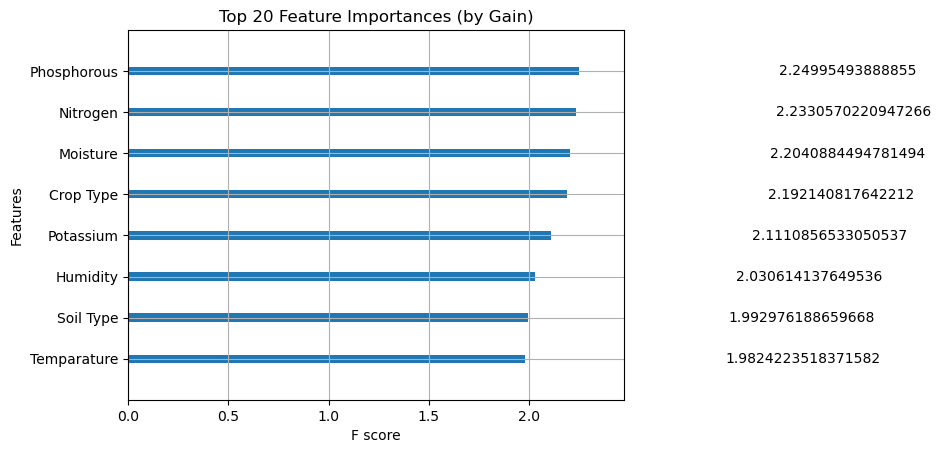

In [34]:
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=20, importance_type='gain')  # gain = nützlichste Metrik
plt.title("Top 20 Feature Importances (by Gain)")
plt.show()

Accuracy: 0.19976


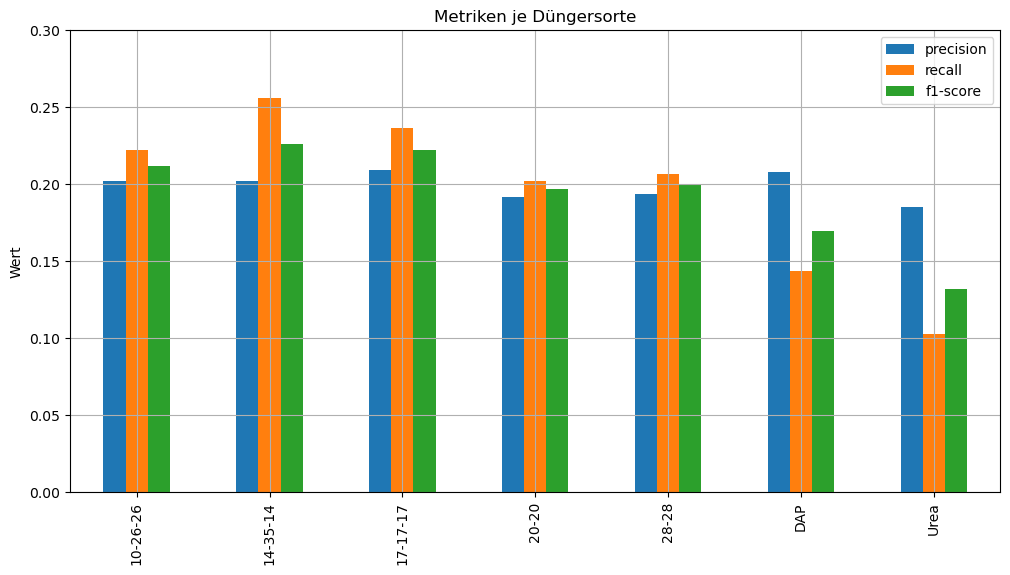

In [36]:
print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred, target_names=target_le.classes_))

report = classification_report(y_test, y_pred, target_names=target_le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:-3][["precision", "recall", "f1-score"]].plot(kind="bar", figsize=(12,6))
plt.title("Metriken je Düngersorte")
plt.ylabel("Wert")
plt.ylim(0, 0.3)
plt.grid(True)
plt.show()

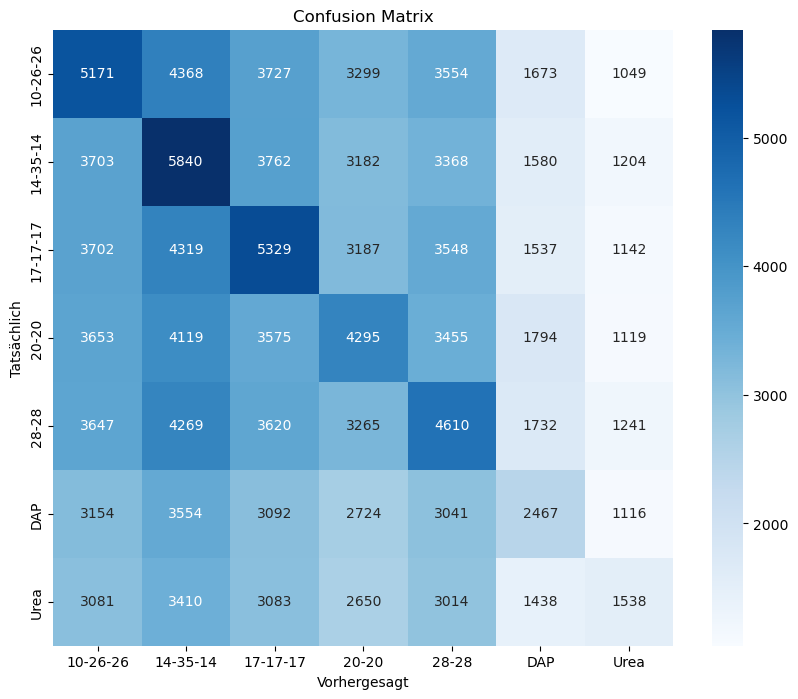

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_le.classes_, yticklabels=target_le.classes_, cmap="Blues")
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix")
plt.show()


## Quellen:
[Yunaki Kuchi's Code on Kaggle](https://www.kaggle.com/code/yunakikuchi/lastd)<br>
[ChatGTP RandomForrest](https://chatgpt.com/s/t_6887ad1370ec8191b03715c28def00c4)<br>
[XGBoost Tuturial](https://www.tutorialspoint.com/xgboost/xgboost-python-implementation.htm)
